# Data Extraction

In [1]:
import pandas as pd
data = pd.read_csv('Dataset.csv')

print(data.shape)
data.head()

(4401, 2)


,Label,Tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


# Data Prepocessing

In [2]:
x = data['Tweet']

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

stopwords = StopWordRemoverFactory().get_stop_words() 
stemmer = StemmerFactory().create_stemmer()

import re 

def text_preprocess(text, stemmer, stopwords):
    x = text.str.replace(r'\W',' ')
    x = x.str.replace(r'\s+',' ')
    x = x.str.lower()
    x = x.apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split() if item not in stopwords]))
    return x

data['processed_text'] = text_preprocess(x, stemmer, stopwords)

In [3]:
data['processed_text']

0       soal jln jatibaru polisi tdk bs gertak gubernu...
1       sama cewe lho kayak harus lebih rasain lah sib...
2       kepingin gudeg mbarek bu hj amad foto google s...
3       jln jatibaru bagi wilayah tn abang atur wilaya...
4       sharing alam aja kemarin jam 18 00 batalin tik...
                              ...                        
4396    tahu kamu papa mejam mata tahan gejolak batin ...
4397    sulit tetap calon wapresnya jokowi pilpres 201...
4398    5 masa depan jelas lha iya gimana mau jelas co...
4399    username dulu beneran mahasiswa teknik ui nemb...
4400       allah engkau tahu rasa sakit hati sembuh allah
Name: processed_text, Length: 4401, dtype: object

In [4]:
import nltk
nltk.download()

wordfreq = {}
for sentence in data['processed_text']:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

import heapq
most_freq = heapq.nlargest(300, wordfreq, key=wordfreq.get)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [5]:
wordfreq = {token: freq for token, freq in sorted(wordfreq.items(), key=lambda item: item[1], reverse=True)} 
wordfreq

{'username': 1794,
 'yg': 1681,
 'aku': 1301,
 'sama': 906,
 'jadi': 774,
 'orang': 736,
 'ga': 730,
 'aja': 637,
 'url': 622,
 'mau': 609,
 'kalo': 581,
 'gue': 570,
 'apa': 550,
 'cinta': 543,
 'sayang': 526,
 'kamu': 520,
 'buat': 517,
 'udah': 483,
 'gak': 474,
 'takut': 449,
 'rasa': 346,
 'banget': 345,
 'nya': 344,
 'sih': 341,
 'lebih': 335,
 'banyak': 333,
 'semua': 312,
 'baik': 309,
 'selalu': 301,
 'tak': 292,
 'hari': 288,
 'tau': 280,
 'suka': 276,
 'gitu': 275,
 'kalau': 270,
 'gw': 268,
 'salah': 265,
 'anak': 262,
 'tp': 260,
 'terus': 260,
 'hati': 259,
 'ku': 259,
 'sendiri': 258,
 'bukan': 258,
 'pas': 258,
 'kan': 248,
 'pernah': 247,
 'baru': 243,
 'diri': 238,
 'bikin': 237,
 'satu': 233,
 'punya': 232,
 'jangan': 231,
 'cuma': 229,
 'dulu': 229,
 'kasih': 227,
 'kata': 222,
 'jalan': 222,
 'gua': 214,
 'hidup': 209,
 'malah': 203,
 'bgt': 201,
 'si': 197,
 'sampe': 196,
 'moga': 194,
 'nyata': 192,
 'lah': 190,
 'makin': 189,
 'bilang': 188,
 'lama': 188,
 'akhi

# Feature Bag of Word (BOW)

In [6]:
import numpy as np  
import random  
import string

sentence_vectors = []
for sentence in data['processed_text']:
    sentence_tokens = nltk.word_tokenize(sentence)
    sent_vec = []
    for token in most_freq:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)

sentence_vectors = np.asarray(sentence_vectors)
print(sentence_vectors)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Feature TF-IDF

In [7]:
word_idf_values = {}
for token in most_freq:
    doc_containing_word = 0
    for document in data['processed_text']:
        if token in nltk.word_tokenize(document):
            doc_containing_word += 1
    word_idf_values[token] = np.log(len(x)/(1 + doc_containing_word))


word_tf_values = {}
for token in most_freq:
    sent_tf_vector = []
    for document in data['processed_text']:
        doc_freq = 0
        for word in nltk.word_tokenize(document):
            if token == word:
                  doc_freq += 1
        word_tf = doc_freq/len(nltk.word_tokenize(document))
        sent_tf_vector.append(word_tf)
    word_tf_values[token] = sent_tf_vector
    
tfidf_values = []
for token in word_tf_values.keys():
    tfidf_sentences = []
    for tf_sentence in word_tf_values[token]:
        tf_idf_score = tf_sentence * word_idf_values[token]
        tfidf_sentences.append(tf_idf_score)
    tfidf_values.append(tfidf_sentences)

tf_idf_model = np.asarray(tfidf_values)
tf_idf_model = np.transpose(tf_idf_model)

print(tf_idf_model)

[[0.09313375 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.04977838 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# Labelling Target

In [8]:
from sklearn.preprocessing import LabelEncoder
le_label = LabelEncoder()

data['Label'] = le_label.fit_transform(data['Label'])
y = data['Label']

In [9]:
y

0       0
1       0
2       2
3       0
4       2
       ..
4396    3
4397    1
4398    0
4399    2
4400    4
Name: Label, Length: 4401, dtype: int32

# Modelling Using NaiveBayes

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentence_vectors, y, test_size=(0.3))

In [12]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(x_train, y_train)
print('Accuracy of Naive bayes classifier on training set: {:.2f}'
     .format(model.score(x_train, y_train)))
print('Accuracy of Naive bayes classifier on test set: {:.2f}'
    .format(model.score(x_test, y_test)))

Accuracy of Naive bayes classifier on training set: 0.54
Accuracy of Naive bayes classifier on test set: 0.46


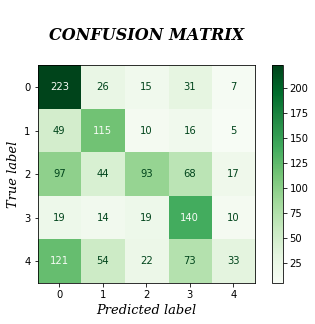

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, plot_confusion_matrix

# plot confusion matriks
plot_confusion_matrix(model, x_test, y_test,
                    cmap=plt.cm.Greens,
                    values_format='.4g')

plt.title('\nCONFUSION MATRIX\n', size=16, weight='bold', style='oblique', family='serif')
plt.ylabel('True label', size=13, weight='medium', style='oblique', family='serif')
plt.xlabel('Predicted label', size=13, weight='medium', style='oblique', family='serif')
plt.show()

In [14]:
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.74      0.55       302
           1       0.45      0.59      0.51       195
           2       0.58      0.29      0.39       319
           3       0.43      0.69      0.53       202
           4       0.46      0.11      0.18       303

    accuracy                           0.46      1321
   macro avg       0.47      0.48      0.43      1321
weighted avg       0.48      0.46      0.42      1321



# Modelling Using LogisticRegression 

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tf_idf_model, y, test_size=(0.3))

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(x_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
    .format(logreg.score(x_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.65
Accuracy of Logistic regression classifier on test set: 0.57


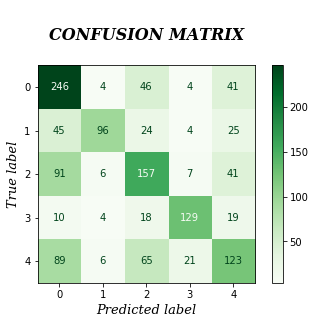

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, plot_confusion_matrix

# plot confusion matriks
plot_confusion_matrix(logreg, x_test, y_test,
                    cmap=plt.cm.Greens,
                    values_format='.4g')

plt.title('\nCONFUSION MATRIX\n', size=16, weight='bold', style='oblique', family='serif')
plt.ylabel('True label', size=13, weight='medium', style='oblique', family='serif')
plt.xlabel('Predicted label', size=13, weight='medium', style='oblique', family='serif')
plt.show()

In [18]:
y_pred = logreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.72      0.60       341
           1       0.83      0.49      0.62       194
           2       0.51      0.52      0.51       302
           3       0.78      0.72      0.75       180
           4       0.49      0.40      0.44       304

    accuracy                           0.57      1321
   macro avg       0.62      0.57      0.58      1321
weighted avg       0.59      0.57      0.57      1321

